In [1]:
import cartopy.crs as ccrs
import faceted
import matplotlib.dates as mdates
import matplotlib.units as munits
import numpy as np
import pandas as pd
import xarray as xr
import wandb

import plotting
import utils

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter

In [2]:
plotting.configure_style()

In [3]:
TIME_SERIES_MODELS = ["SHiELD-SOM-C96", "ACE2-SOM-multi-climate-RS3"]
ONE_DEGREE_MODELS = ["SHiELD-SOM-C96", "ACE2-SOM-multi-climate-RS3"]
FOUR_DEGREE_MODELS = [
    "SHiELD-SOM-C96",
    "ACE2-SOM-multi-climate-RS3",
    "SHiELD-SOM-C24-tuned-cdmbgwd",
]
CLIMATES = ["3xCO2"]
VARIABLES = [
    "column_moist_static_energy",
    "net_energy_flux_into_atmospheric_column",
    "column_moist_static_energy_tendency",
]
TIMESTEP_SECONDS = 6 * 3600

catalog = pd.read_csv("../scripts/inference-run-catalog.csv")

In [4]:
def load_global_metrics(wandb_run, variables):
    pattern = "inference/mean/weighted_mean_gen/{variable}"
    keys = [pattern.format(variable=variable) for variable in variables]
    metrics = pd.DataFrame(wandb_run.scan_history(keys=keys))

    metrics["time"] = pd.date_range(
        "2031-01-01T06", periods=len(metrics.index), freq="6h"
    )
    metrics = metrics.set_index("time")

    ds = xr.Dataset.from_dataframe(metrics)
    ds = ds.rename({pattern.format(variable=v): v for v in variables})
    return ds


def load_time_series_data(catalog, models, climates, variables):
    api = wandb.Api()
    cases = catalog[catalog["model"].isin(models) & catalog["forcing"].isin(climates)]
    datasets = {}
    for _, case in cases.iterrows():
        wandb_run = api.run(case["wandb_id"])
        ds = load_global_metrics(wandb_run, variables)
        key = case["model"], case["forcing"], case["initial_condition"]
        datasets[key] = ds

    index = pd.MultiIndex.from_tuples(
        datasets.keys(), names=("model", "climate", "initial_condition")
    )
    combined = utils.safe_concat(datasets.values(), dim="case")
    result = combined.assign_coords(case=index).unstack("case")
    return utils.scale_precipitation(result)

In [5]:
time_series = load_time_series_data(catalog, TIME_SERIES_MODELS, CLIMATES, VARIABLES)
time_series["mse_budget_residual"] = (
    time_series.column_moist_static_energy_tendency - time_series.net_energy_flux_into_atmospheric_column
)

/tmp/ipykernel_18273/435408726.py:30: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  result = combined.assign_coords(case=index).unstack("case")


In [6]:
one_degree_time_mean = utils.load_time_mean_data(catalog, ONE_DEGREE_MODELS, CLIMATES, VARIABLES).mean(
    "initial_condition"
)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

/home/spencerc/2025-05-07-ACE2-SOM-revisions/ace2-som-paper/notebooks/utils.py:175: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  result = combined.assign_coords(case=index).unstack("case")


In [7]:
regridder = utils.get_regridder()
four_degree_time_mean = utils.load_time_mean_data(catalog, FOUR_DEGREE_MODELS, CLIMATES, VARIABLES, target_resolution=4,
    regridder=regridder).mean(
    "initial_condition"
)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

/home/spencerc/2025-05-07-ACE2-SOM-revisions/ace2-som-paper/notebooks/utils.py:175: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  result = combined.assign_coords(case=index).unstack("case")


In [8]:
one_degree_implied_mse_transport = (
    one_degree_time_mean.column_moist_static_energy_tendency
    - one_degree_time_mean.net_energy_flux_into_atmospheric_column
)
four_degree_implied_mse_transport = (
    four_degree_time_mean.column_moist_static_energy_tendency
    - four_degree_time_mean.net_energy_flux_into_atmospheric_column
)

In [9]:
one_degree_implied_transport_error = one_degree_implied_mse_transport.drop_sel(
    model="SHiELD-SOM-C96"
) - one_degree_implied_mse_transport.sel(model="SHiELD-SOM-C96")
four_degree_implied_transport_error = four_degree_implied_mse_transport.drop_sel(
    model="SHiELD-SOM-C96"
) - four_degree_implied_mse_transport.sel(model="SHiELD-SOM-C96")

In [10]:
weights = np.cos(np.deg2rad(four_degree_implied_mse_transport.lat))
implied_mse_transport_mean = four_degree_implied_mse_transport.weighted(weights).mean(["lat", "lon"]).compute()
implied_transport_rmse = np.sqrt((four_degree_implied_transport_error ** 2).weighted(weights).mean(["lat", "lon"]).compute())

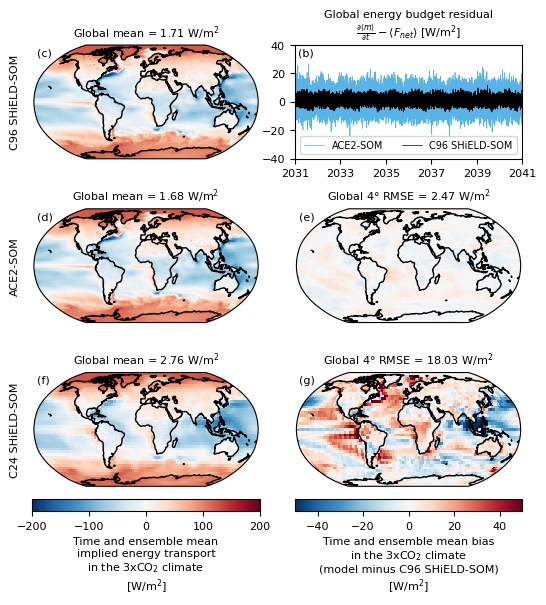

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6), (cax1, cax2) = faceted.faceted(
    3,
    2,
    width=5.5,
    aspect=0.5,
    cbar_mode="edge",
    cbar_location="bottom",
    cbar_pad=0.125,
    internal_pad=(0.35, 0.5),
    axes_kwargs={"projection": ccrs.Robinson()},
    bottom_pad=0.85,
    top_pad=0.4,
    left_pad=0.35
)

position = ax2.get_position(original=True)
ax2.set_visible(False)
ax2 = fig.add_axes(position)

vmin, vmax = -200, 200
cmap = "RdBu_r"

p1 = (
    one_degree_implied_mse_transport.sel(model="SHiELD-SOM-C96")
    .squeeze("climate")
    .plot(
        ax=ax1,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
)
p1 = (
    one_degree_implied_mse_transport.sel(model="ACE2-SOM-multi-climate-RS3")
    .squeeze("climate")
    .plot(
        ax=ax3,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
)
p1 = (
    four_degree_implied_mse_transport.sel(model="SHiELD-SOM-C24-tuned-cdmbgwd")
    .squeeze("climate")
    .plot(
        ax=ax5,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
)

vmin, vmax = -50, 50
cmap = "RdBu_r"

p2 = one_degree_implied_transport_error.squeeze("climate").plot(
    ax=ax4,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
p2 = four_degree_implied_transport_error.squeeze("climate").sel(model="SHiELD-SOM-C24-tuned-cdmbgwd").plot(
    ax=ax6,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)

for ax in (ax1, ax3, ax4, ax5, ax6):
    ax.coastlines()

for initial_condition in time_series.initial_condition:
    if initial_condition.item() == "ic1":
        label_shield = "C96 SHiELD-SOM"
        label_ace = "ACE2-SOM"
    else:
        label_shield = None
        label_ace = None
    time_series.mse_budget_residual.sel(initial_condition=initial_condition, model="ACE2-SOM-multi-climate-RS3").plot(ax=ax2, color="C0", lw=0.5, label=label_ace)
    time_series.mse_budget_residual.sel(initial_condition=initial_condition, model="SHiELD-SOM-C96").plot(ax=ax2, color="k", lw=0.5, label=label_shield)

ax2.set_xlim(pd.Timestamp("2031-01-01"), pd.Timestamp("2041-01-01"))
ax2.set_xticks(pd.date_range("2031", periods=6, freq="2YS"))
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title("Global energy budget residual\n" + r"$\frac{\partial\left< m \right>}{\partial t} - \left<F_{net}\right>$ [W/m$^2$]")
ax2.set_ylim(-40, 40)

ax1.set_title(f"Global mean = {implied_mse_transport_mean.sel(model='SHiELD-SOM-C96').item():0.2f} W/m$^2$")
ax3.set_title(f"Global mean = {implied_mse_transport_mean.sel(model='ACE2-SOM-multi-climate-RS3').item():0.2f} W/m$^2$")
ax5.set_title(f"Global mean = {implied_mse_transport_mean.sel(model='SHiELD-SOM-C24-tuned-cdmbgwd').item():0.2f} W/m$^2$")
ax4.set_title(f"Global 4° RMSE = {implied_transport_rmse.sel(model='ACE2-SOM-multi-climate-RS3').item():0.2f} W/m$^2$")
ax6.set_title(f"Global 4° RMSE = {implied_transport_rmse.sel(model='SHiELD-SOM-C24-tuned-cdmbgwd').item():0.2f} W/m$^2$")

ax1.annotate(
    "C96 SHiELD-SOM",
    xy=(0, 0.5),
    xytext=(-10, 0),
    xycoords="axes fraction",
    textcoords="offset points",
    ha="right",
    va="center",
    rotation=90,
)
ax3.annotate(
    "ACE2-SOM",
    xy=(0, 0.5),
    xytext=(-10, 0),
    xycoords="axes fraction",
    textcoords="offset points",
    ha="right",
    va="center",
    rotation=90,
)
ax5.annotate(
    "C24 SHiELD-SOM",
    xy=(0, 0.5),
    xytext=(-10, 0),
    xycoords="axes fraction",
    textcoords="offset points",
    ha="right",
    va="center",
    rotation=90,
)

ax2.annotate(
    "(b)",
    xy=(0, 1),
    xytext=(2, -2),
    va="top",
    xycoords="axes fraction",
    textcoords="offset points",
)

for ax, label in zip((ax1, ax3, ax4, ax5, ax6), ("c", "d", "e", "f", "g")):
    ax.annotate(
        f"({label})",
        xy=(0, 1),
        xytext=(2, -2),
        va="top",
        xycoords="axes fraction",
        textcoords="offset points",
    )

fig.colorbar(
    p1,
    cax=cax1,
    orientation="horizontal",
    label="Time and ensemble mean\nimplied energy transport\nin the 3xCO$_2$ climate\n[W/m$^2$]",
)
fig.colorbar(
    p2,
    cax=cax2,
    orientation="horizontal",
    label="Time and ensemble mean bias\nin the 3xCO$_2$ climate\n(model minus C96 SHiELD-SOM)\n[W/m$^2$]",
)

ax2.legend(ncol=2, fontsize=7, loc="lower center")

fig.savefig("figures/figure-S02.pdf")